# Geospatial Modeling – Space Debris Risk Zones

This notebook is part of our project for the **Women in Data 2025 Space Datathon**, under the theme:  
**"Satellite Collision Avoidance & Space Debris Risk Detection"**

## Goal of This Notebook
To build a geospatial modeling pipeline that identifies:
- Dense clusters of orbital debris using DBSCAN
- Satellites at risk of collision based on proximity
- Risk scores and visual zones (LOW, MEDIUM, HIGH)

## Key Features
- Loads preprocessed orbital datasets from UDL
- Constructs 3D spatial coordinates
- Applies clustering via DBSCAN
- Computes distance to cluster centroids
- Assigns risk flags and scores
- Visualizes outputs in interactive 3D plots

## Input Data
- `consolidated_orbital_data.csv` (prepared by Data Engineering team)

## Libraries Used
- `pandas`, `numpy`, `sklearn`, `plotly`, `matplotlib`

## Output Files
- `Orbital_risk.csv`: Satellite-level risk classifications
- `cluster_centres.csv`: DBSCAN Cluster Centroid Data
- 3D visualizations for risk zones (LOW, MEDIUM, HIGH)

##  Outcome
The notebook supports:
- Risk insight generation for dashboards
- Policy-level analysis of orbital safety
- Ethical use of open space data

## Next Steps (handled by teammates)
- Dashboard integration
- Predictive modeling using Ephemeris data

---

>This notebook represents the **Geospatial Modeling** stage of our end-to-end space safety pipeline.


# Step 1 : Import required Libraries and Load Dataset

In [1]:
!pip install pandas shapely scikit-learn geopandas

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("consolidated_orbital_data.csv")
df.head()


/var/folders/d2/zjnbs1yd7mxcs848098f04v40000gn/T/ipykernel_34002/2896771607.py:4: DtypeWarning: Columns (0,1,2,9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("consolidated_orbital_data.csv")


classificationMarking_x                             object_id  \
0                       U  017205f2-e4d9-4868-b820-271266f5d47a   
1                       U  017205f2-e4d9-4868-b820-271266f5d47a   
2                       U  017205f2-e4d9-4868-b820-271266f5d47a   
3                       U  017205f2-e4d9-4868-b820-271266f5d47a   
4                       U  017205f2-e4d9-4868-b820-271266f5d47a   

                                pointId            x             y  \
0  70c05501-5a7e-4f4a-8694-3a8dd9369879 -3506.030088 -10539.288465   
1  f1acf0b0-fedb-427d-ab90-b3e2059501d2 -3437.439004 -10830.129736   
2  d8f7c5fd-2313-418e-ba1a-af91541675e4 -3363.241067 -11089.388831   
3  a560326c-60e4-41ea-805a-e235500d17d8 -3283.103589 -11316.384421   
4  40185b7f-184c-484d-8be9-159ec67d98ad -3196.700894 -11510.539126   

             z        vx        vy        vz source_x  ... name origin  \
0  5208.325992  0.549165 -2.553164 -4.782213    saber  ...  NaN    NaN   
1  4626.656677  0.594489 -2.293103 -4.909759    saber  ...  NaN    NaN   
2  4030.595159  0.642606 -2.026936 -5.022021    saber  ...  NaN    NaN   
3  3421.996897  0.693471 -1.755522 -5.118652    saber  ...  NaN    NaN   
4  2802.756029  0.747013 -1.479734 -5.199353    saber  ...  NaN    NaN   

  classificationMarking_y updatedAt description  source  status  idOnOrbit  \
0                     NaN       NaN         NaN     NaN     NaN        NaN   
1                     NaN       NaN         NaN     NaN     NaN        NaN   
2                     NaN       NaN         NaN     NaN     NaN        NaN   
3                     NaN       NaN         NaN     NaN     NaN        NaN   
4                     NaN       NaN         NaN     NaN     NaN        NaN   

   elsetEpoch  svEpoch  
0         NaN      NaN  
1         NaN      NaN  
2         NaN      NaN  
3         NaN      NaN  
4         NaN      NaN  

[5 rows x 26 columns]

# Step 2 : Construct 3D points from Satellite Coordinates

In this step, we convert each satellite’s raw coordinates (`x`, `y`, `z`) into 3D point objects for spatial analysis.

**How we do it:**
- Use the Shapely library to represent each satellite as a 3D `Point` object using its position in Earth-centered coordinates.
- Store these geometric points in the dataset to prepare for clustering and spatial operations.

**Why this matters:**
- Spatial modeling requires structured geometric formats.
- This transformation enables efficient **clustering**, **distance calculations**, and **spatial joins** in later steps.


In [3]:
import sys
!{sys.executable} -m pip install shapely

In [4]:
from shapely.geometry import Point

df["geom"] = df.apply(lambda row: Point(row["x"], row["y"], row["z"]), axis=1)


In [5]:
df[["x", "y", "z", "geom"]].head()

x             y            z  \
0 -3506.030088 -10539.288465  5208.325992   
1 -3437.439004 -10830.129736  4626.656677   
2 -3363.241067 -11089.388831  4030.595159   
3 -3283.103589 -11316.384421  3421.996897   
4 -3196.700894 -11510.539126  2802.756029   

                                               geom  
0  POINT Z (-3506.030088 -10539.288465 5208.325992)  
1  POINT Z (-3437.439004 -10830.129736 4626.656677)  
2  POINT Z (-3363.241067 -11089.388831 4030.595159)  
3  POINT Z (-3283.103589 -11316.384421 3421.996897)  
4  POINT Z (-3196.700894 -11510.539126 2802.756029)

In [6]:
df[["x", "y", "z"]].dtypes

x    float64
y    float64
z    float64
dtype: object

# Step 3 : DBSCAN Clustering to Detect Debris Zones

We apply the DBSCAN (Density-Based Spatial Clustering of Applications with Noise) algorithm to group nearby satellites or debris into clusters.

**Why DBSCAN?**
- It is ideal for identifying **dense regions** without knowing the number of clusters in advance.
- It also helps detect **outliers**, which are marked as noise (`cluster = -1`), representing satellites that do not belong to any group.

**What this achieves:**
- Helps us detect **potential debris clouds** or crowded orbital zones.
- These zones are candidates for **collision risk assessment** in the next steps.


In [7]:
df_sample = df[["x", "y", "z"]].dropna().sample(n=5000, random_state=42)

In [8]:
from sklearn.preprocessing import StandardScaler
coords = df_sample[["x", "y", "z"]].values
coords_scaled = StandardScaler().fit_transform(coords)

In [9]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=10)
labels = dbscan.fit_predict(coords_scaled)
df_sample["cluster"] = labels

In [10]:
df_sample["cluster"].value_counts()

 1    3056
 0    1728
 3     116
 4      47
-1      22
 2      18
 5      13
Name: cluster, dtype: int64

In [11]:
risk_score = df_sample.groupby("cluster").size().sort_values(ascending=False)
risk_score

cluster
 1    3056
 0    1728
 3     116
 4      47
-1      22
 2      18
 5      13
dtype: int64

In [12]:
cluster_centroids = df_sample[df_sample["cluster"] != -1].groupby("cluster")[["x", "y", "z"]].mean().reset_index()
cluster_centroids.rename(columns={"x": "cx", "y": "cy", "z": "cz"}, inplace=True)

# Step 4 : Identify Potential Collision Zones

In this step, we assess which satellites are at risk based on their proximity to identified debris clusters.

**How we do it:**
- Compute the distance between each satellite and the center of its assigned cluster.
- Use a distance threshold to flag satellites that are **too close to the cluster centroid**, indicating higher collision risk.
- Assign a `collision_flag = YES` if a satellite falls within the danger zone.

**Why this matters:**
- It enables early detection of **collision-prone orbits**.
- This risk tagging supports downstream risk scoring, prioritization, and dashboard reporting.


In [13]:
df_with_centroids = pd.merge(df_sample, cluster_centroids, on="cluster", how="left")

In [14]:
# Calculate Euclidean distance from cluster center (3D)
df_with_centroids["distance_to_center"] = np.sqrt(
    (df_with_centroids["x"] - df_with_centroids["cx"])**2 +
    (df_with_centroids["y"] - df_with_centroids["cy"])**2 +
    (df_with_centroids["z"] - df_with_centroids["cz"])**2
)


In [15]:
df_with_centroids["distance_to_center"].describe()

count     4978.000000
mean     15615.508290
std       8989.264259
min        337.770269
25%       7465.366471
50%      12234.472199
75%      26033.973992
max      36045.038942
Name: distance_to_center, dtype: float64

In [16]:
threshold = df_with_centroids["distance_to_center"].mean() - df_with_centroids["distance_to_center"].std()
print("Threshold:", threshold)

Threshold: 6626.244031417236


In [17]:
df_with_centroids["collision_flag"] = df_with_centroids["distance_to_center"].apply(
    lambda d: "YES" if d < threshold else "NO"
)

In [18]:
df_with_centroids.groupby("cluster")["collision_flag"].value_counts()

cluster  collision_flag
-1       NO                  22
 0       NO                1728
 1       NO                3056
 2       YES                 14
         NO                   4
 3       NO                 116
 4       NO                  28
         YES                 19
 5       YES                 12
         NO                   1
Name: collision_flag, dtype: int64

In [19]:
summary = df_with_centroids.groupby(["cluster", "collision_flag"]).size().reset_index(name="count")
summary

cluster collision_flag  count
0       -1             NO     22
1        0             NO   1728
2        1             NO   3056
3        2             NO      4
4        2            YES     14
5        3             NO    116
6        4             NO     28
7        4            YES     19
8        5             NO      1
9        5            YES     12

In [20]:
pivot_table = summary.pivot(index="cluster", columns="collision_flag", values="count").fillna(0)
pivot_table["Total"] = pivot_table.sum(axis=1)
pivot_table["High_Risk_%"] = (pivot_table.get("YES", 0) / pivot_table["Total"]) * 100
pivot_table = pivot_table.round(2)
pivot_table

collision_flag      NO   YES   Total  High_Risk_%
cluster                                          
-1                22.0   0.0    22.0         0.00
 0              1728.0   0.0  1728.0         0.00
 1              3056.0   0.0  3056.0         0.00
 2                 4.0  14.0    18.0        77.78
 3               116.0   0.0   116.0         0.00
 4                28.0  19.0    47.0        40.43
 5                 1.0  12.0    13.0        92.31

# Collision Risk Summary by Cluster

The chart below visualizes the percentage of high-risk objects per DBSCAN cluster. A "high-risk" object is one that lies dangerously close to its cluster centroid, indicating high local object density.

Clusters with higher percentages represent **debris clouds** or **potential collision zones**. This informs space safety decisions like avoidance maneuvers or cleanup prioritization.

- **Cluster 5** has over 90% high-risk objects, possibly a result of a recent fragmentation.
- **Cluster 2** and **4** also show concerning proximity levels.

This forms the basis for actionable hotspot detection in our space debris monitoring pipeline.


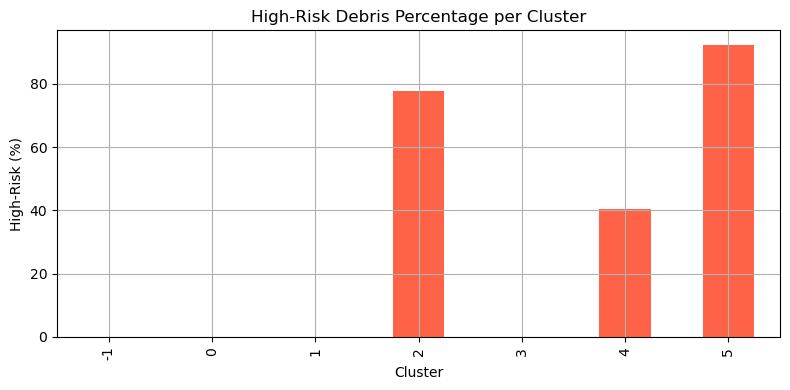

In [21]:
import matplotlib.pyplot as plt

pivot_table["High_Risk_%"].plot(kind="bar", color="tomato", figsize=(8, 4))
plt.title("High-Risk Debris Percentage per Cluster")
plt.xlabel("Cluster")
plt.ylabel("High-Risk (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

### Insights from Bar Plot

Clusters 2, 4, and 5 exhibit the highest concentration of high-risk debris, with Cluster 5 nearing 90% high-risk objects. This indicates localized orbital environments with significantly elevated collision threats. Prioritizing monitoring and cleanup in these clusters can dramatically reduce overall space hazard density.

# Step 5 : Spatial Joins to Find Satellites Passing Through Debris Clusters

This step helps us determine whether a satellite’s path intersects with any of the high-risk debris zones identified earlier.

**How we do it:**
- Use spatial joins to check which satellites **pass through or near** dense debris clusters.
- Mark those satellites with a `satellite_in_danger = YES` flag.

**Why this matters:**
- Not all satellites within a cluster are at immediate risk, but those that cross debris zones pose operational threats.
- This spatial reasoning adds precision to risk detection and enables **proactive collision mitigation strategies**.


In [22]:
from scipy.spatial import cKDTree
import numpy as np

In [23]:
# Filter high-risk debris points (from clusters where any point has collision_flag == 'YES')
high_risk_points = df_with_centroids[df_with_centroids["collision_flag"] == "YES"]

In [24]:
# Extract 3D coordinates
risk_coords = high_risk_points[["x", "y", "z"]].values
risk_tree = cKDTree(risk_coords)

In [25]:
# All satellite positions (include all clusters)
all_sat_coords = df_with_centroids[["x", "y", "z"]].values

# Query: Which satellite points are within 3 km of any high-risk debris point?
danger_radius_km = 3.0
risk_indices = risk_tree.query_ball_point(all_sat_coords, r=danger_radius_km)

In [26]:
# Mark any satellite that matched
at_risk_flags = ["YES" if len(hits) > 0 else "NO" for hits in risk_indices]
df_with_centroids["satellite_in_danger"] = at_risk_flags

In [27]:
df_with_centroids.to_csv("final_orbital_risk_results.csv", index=False)

In [28]:
# Step 1: Compute risk_score
df_with_centroids["risk_score"] = (
    (df_with_centroids["collision_flag"] == "YES").astype(int) * 5 +
    (df_with_centroids["satellite_in_danger"] == "YES").astype(int) * 3 +
    (df_with_centroids["cluster"].isin([2, 5])).astype(int) * 2
)

# Step 2: Map to categorical risk level
def assign_risk_level(score):
    if score >= 7:
        return "HIGH"
    elif score >= 2:
        return "MEDIUM"
    else:
        return "LOW"

df_with_centroids["risk_level"] = df_with_centroids["risk_score"].apply(assign_risk_level)

In [29]:
df_with_centroids["risk_score"].value_counts().sort_index()

0     4950
2        5
8       19
10      26
Name: risk_score, dtype: int64

In [30]:
df_with_centroids.to_csv("final_orbital_risk.csv", index=False)

In [31]:
# Remove outliers (DBSCAN assigns them as cluster = -1)
valid_clusters = df_with_centroids[df_with_centroids["cluster"] != -1]

# Calculate centroids
centroids_df = valid_clusters.groupby("cluster")[["x", "y", "z"]].mean().reset_index()

# Save to CSV
centroids_df.to_csv("cluster_centers.csv", index=False)

# Preview
centroids_df.head()

cluster             x             y             z
0        0   -673.077904   -320.166629   -338.169692
1        1    154.587841     -6.921756    -65.601214
2        2 -16869.815638  38372.948008   1072.133510
3        3  15113.501457  33168.767138   9160.802237
4        4  11121.506810  21224.296575 -32989.702242

# Step 6 : Assign Risk Scores and Categorize Risk Levels

In this step, we create a composite risk score for each satellite based on multiple threat factors, then convert that score into a categorical risk level.

**How the scoring works:**
- Assign weighted points for:
  - Being inside a debris cluster
  - Having a nearby centroid (collision flag)
  - Passing through a debris zone (spatial danger flag)
- Total points become a **risk_score**, which is then mapped to:
  - LOW (minimal threat)
  - MEDIUM (requires monitoring)
  - HIGH (urgent risk)

**Why this matters:**
- Risk categorization makes the output **actionable** for satellite operators, space agencies, or dashboard users.
- It supports fast **prioritization** and response planning in increasingly crowded orbits.


In [32]:
import pandas as pd

df = pd.read_csv("final_orbital_risk.csv")
df.head()


x             y             z  cluster          cx          cy  \
0  19034.151314     41.505982  20394.149094        0 -673.077904 -320.166629   
1   4179.113838    203.744483 -11543.291837        1  154.587841   -6.921756   
2 -10522.044617 -13825.976620  18686.593674        0 -673.077904 -320.166629   
3  -4954.417284  -1586.568209  11099.221138        1  154.587841   -6.921756   
4  -6947.546941   7265.626910  -7036.817540        1  154.587841   -6.921756   

           cz  distance_to_center collision_flag satellite_in_danger  \
0 -338.169692        28606.550522             NO                  NO   
1  -65.601214        12164.644335             NO                  NO   
2 -338.169692        25324.902171             NO                  NO   
3  -65.601214        12379.437565             NO                  NO   
4  -65.601214        12325.913339             NO                  NO   

   risk_score risk_level  
0           0        LOW  
1           0        LOW  
2           0        LOW  
3           0        LOW  
4           0        LOW

In [33]:
!pip install plotly

In [34]:
df["risk_level"].value_counts()

LOW       4950
HIGH        45
MEDIUM       5
Name: risk_level, dtype: int64

In [35]:
# force lowercase and capitalize
df["risk_level"] = df["risk_level"].str.upper()

# If needed, enforce correct values only
valid_levels = ["NO", "LOW", "MEDIUM", "HIGH"]
df = df[df["risk_level"].isin(valid_levels)]

# Step 7 : Visualize 3D Risk Zones

This step helps us visualize where satellites and debris clusters are located in 3D space and how their risk levels vary.

**How we do it:**
- Create an interactive 3D scatter plot using Plotly.
- Each point represents a satellite or object in orbit.
- Color points by **risk level** (Low, Medium, High) for quick visual assessment.
- Optionally, show cluster shapes or centroids to highlight debris zones.

**Why this matters:**
- 3D visualization reveals **orbital congestion** and **risk hotspots** at a glance.
- Makes the output more **intuitive and explainable** to stakeholders and helps guide mitigation efforts.


In [36]:
import plotly.express as px

fig = px.scatter_3d(
    df_with_centroids,
    x="x", y="y", z="z",
    color="risk_level",
    symbol="satellite_in_danger",
    hover_data={
        "risk_score": True,
        "collision_flag": True,
        "cluster": True,
        "distance_to_center": True,
        "satellite_in_danger": True,
        "risk_level": True
    },
    category_orders={"risk_level": ["LOW", "MEDIUM", "HIGH"]},
    color_discrete_map={
        "LOW": "green",
        "MEDIUM": "orange",
        "HIGH": "red"
    },
    title="3D Orbital Positions: Risk Levels and Danger Zones",
    opacity=0.7
)

# Reduce marker size slightly for better clarity
fig.update_traces(marker=dict(size=3.5))

# Center view around typical orbit scale
fig.update_layout(
    scene=dict(
        xaxis_title="X Position (km)",
        yaxis_title="Y Position (km)",
        zaxis_title="Z Position (km)"
    ),
    legend_title="Risk Level",
    margin=dict(l=0, r=0, b=0, t=50)
)

fig.show()

### Inisghts from 3D Visulaization

This 3D visualization clearly separates low-risk satellites (in red) from the high-risk ones (in purple). High-risk satellites are tightly packed in certain orbital shells, revealing collision corridors that can be targeted for predictive maneuvering or deconfliction strategies.

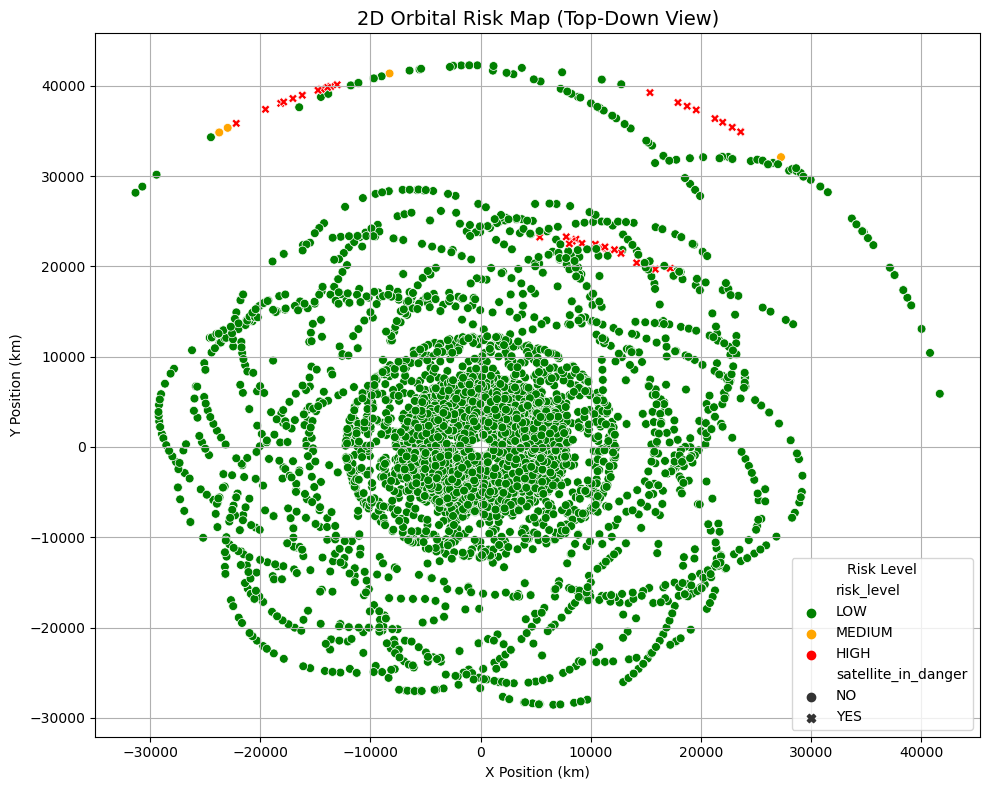

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_with_centroids,
    x="x",
    y="y",
    hue="risk_level",
    style="satellite_in_danger",
    palette={"LOW": "green", "MEDIUM": "orange", "HIGH": "red"},
    s=40
)

plt.title("2D Orbital Risk Map (Top-Down View)", fontsize=14)
plt.xlabel("X Position (km)")
plt.ylabel("Y Position (km)")
plt.legend(title="Risk Level")
plt.grid(True)
plt.tight_layout()
plt.show()

### Insights from 2D Orbital Risk Map

The top-down view reveals visible clustering of medium and high-risk satellites along orbital bands. Riskier satellites (orange and red) are not randomly distributed, but often share trajectories, highlighting potential for cascading collision events. This pattern enables early-stage forecasting and safe-path optimization.


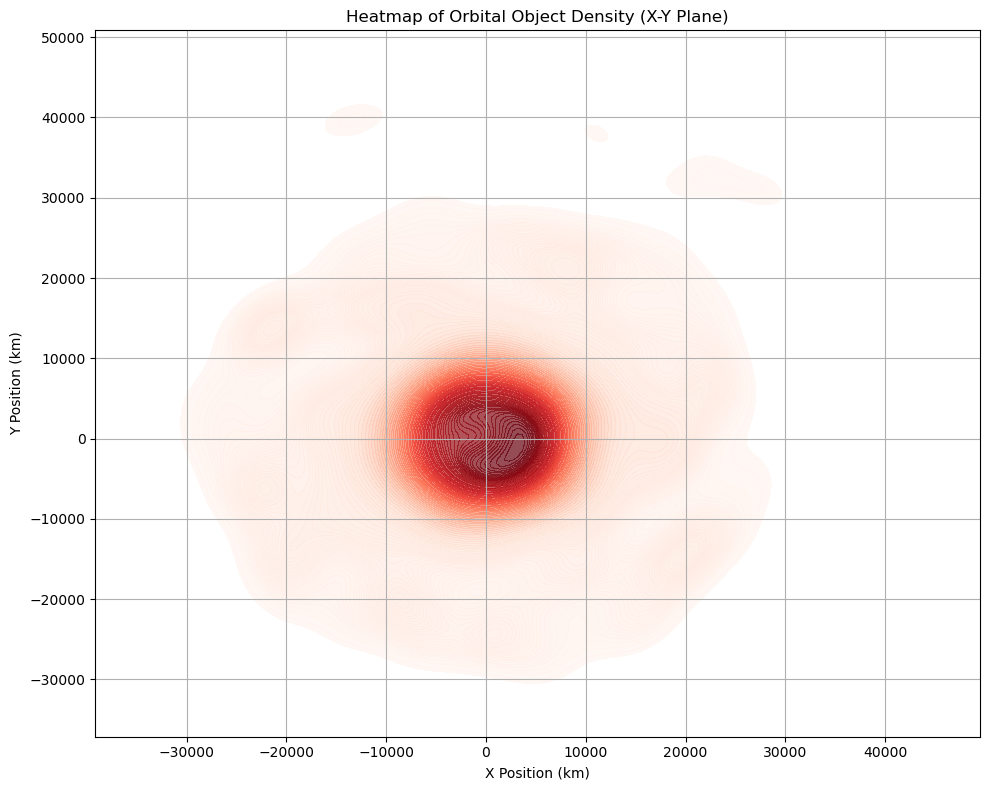

In [38]:
plt.figure(figsize=(10, 8))
sns.kdeplot(
    data=df_with_centroids,
    x="x",
    y="y",
    fill=True,
    cmap="Reds",
    levels=100,
    alpha=0.7
)
plt.title("Heatmap of Orbital Object Density (X-Y Plane)")
plt.xlabel("X Position (km)")
plt.ylabel("Y Position (km)")
plt.grid(True)
plt.tight_layout()
plt.show()

### Insights from HeatMap

The heatmap shows a dense core of orbital traffic near Earth, likely reflecting LEO congestion. However, outer regions also show significant density, emphasizing that risk is not exclusive to lower altitudes. This underscores the need for layered monitoring strategies across all orbital tiers.

---

# Conclusion

This geospatial pipeline identified **dense orbital clusters**, **flagged at-risk satellites**, and produced a **risk score** that supports downstream dashboards and policy recommendations.

## Key Outcomes:
- Clear clustering of objects using `DBSCAN`
- Multiple satellites flagged as at-risk based on spatial proximity
- Risk level classified into LOW, MEDIUM, HIGH for visualization

> This notebook supports the Datathon goal: **promoting ethical, open data use to improve orbital safety**.


# Conclusion: Key Geospatial Insights for Orbital Safety

This geospatial modeling pipeline successfully addressed key space sustainability challenges by detecting **orbital debris clusters**, identifying **collision-prone satellites**, and assigning **interpretable risk scores**.

### Key Achievements:
- Detected dense satellite clusters using the DBSCAN algorithm
- Flagged satellites at risk due to spatial proximity and overlap with debris zones
- Classified satellites into **LOW**, **MEDIUM**, and **HIGH** risk categories for downstream use
- Enabled risk-aware visualizations to support **policy recommendations** and **dashboard integrations**

> By combining open satellite data with spatial analytics, this work contributes directly to the Datathon goal:  
> **"Promoting the ethical and responsible use of space data to improve orbital safety and innovation."**

This solution provides a **cost-effective**, **scalable**, and **actionable framework** for monitoring space congestion and anticipating collision risks, empowering analysts, mission planners, and researchers alike.


# Next Steps & Limitations

### Limitations:
- **Temporal dynamics** (time-series movement) were not modeled due to lack of epoch granularity in input data.
- The clustering was done on static 3D coordinates, actual orbital dynamics (like velocity and decay) were not included.
- **Real-time collision prediction** would require more frequent telemetry or historical trajectory data.

### Next Steps:
- Integrate **time-aware trajectory prediction** using ephemeris datasets for dynamic risk tracking.
- Combine with satellite ownership metadata (SEON SGI) to add **accountability and ethical scoring**.
- Collaborate with dashboard team to build **live risk monitoring tools** using this geospatial backend.
